# WorldCover product access

This notebook demonstrates how ESA WorldCover 2020 and 2021 products can be searched and loaded trough the Terrascope STAC API.


## Install requirements

In [ ]:
!pip install pystac-client geopandas rasterio matplotlib

## Connecting to the Terrascope STAC catalog and search through products

In [2]:
from pystac_client import Client


stac_endopoint = 'https://services.terrascope.be/stac/'

# collection ids for both maps in the Terrascope STAC Catalogue
collection_ids = {2020: 'urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1',
                  2021: 'urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2'}

# WSG84 coordinates of Mol, Belgium
bbox = [5.046776, 51.151453, 5.181290, 51.241861]

client = Client.open(stac_endopoint)

# Let's query products for the 2021 map 
year = 2021
search_results = client.search(
    collections=[collection_ids[year]],
    bbox=bbox
)

# Search results fetched and represented as dictionary
results = search_results.get_all_items()
# results.to_dict()

In [4]:
# explore items metadata
results

ID: urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2:ESA_WorldCover_10m_2021_v200_N51E003
"Bounding Box: [3, 51, 6, 54]"
Datetime: 2021-12-31 23:59:59+00:00
datetime: 2021-12-31T23:59:59Z
title: ESA_WorldCover_10m_2021_v200_N51E003
created: 2022-10-26T14:50:39Z
updated: 2022-10-26T12:52:54Z
start_datetime: 2021-01-01T00:00:00Z
end_datetime: 2021-12-31T23:59:59Z
href: s3://esa-worldcover/v200/2021/map/ESA_WorldCover_10m_2021_v200_N51E003_Map.tif
Title: ESA_WORLDCOVER_10M_MAP


In [10]:
# there is only 1 tile
item = results[0]

# retrieve the s3 path from the item
s3uri = item.assets['ESA_WORLDCOVER_10M_MAP'].href
s3uri

's3://esa-worldcover/v200/2021/map/ESA_WorldCover_10m_2021_v200_N51E003_Map.tif'

## Loading

We'll use `rio-tiler` to load the data

In [ ]:
!pip install rio-tiler

In [19]:
import os
from rio_tiler.io import STACReader

# this is to tell GDAL we do not need authentication
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# name of the map asset
asset = 'ESA_WORLDCOVER_10M_MAP'

with STACReader(None, item=item) as stac:
    img = stac.part(bbox, assets=asset)

## Visualization

To convert the map to an rgb image we'll import an utility from `utils/labels.py`

In [27]:
from utils.labels import label_to_rgb

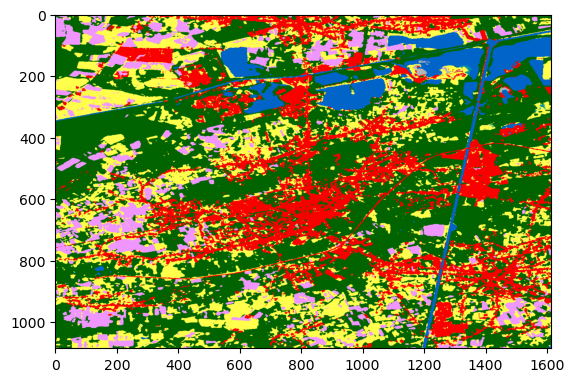

In [30]:
import matplotlib.pyplot as plt

rgb_data = label_to_rgb(img.data[0])
fig, ax = plt.subplots()
ax.imshow(rgb_data)

## Landcover statistics

We will create a bar plot giving the proportion of land cover classes in our study region.

Computing coverage statistics would be more accurate in 

/tmp/ipykernel_10829/2373653344.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


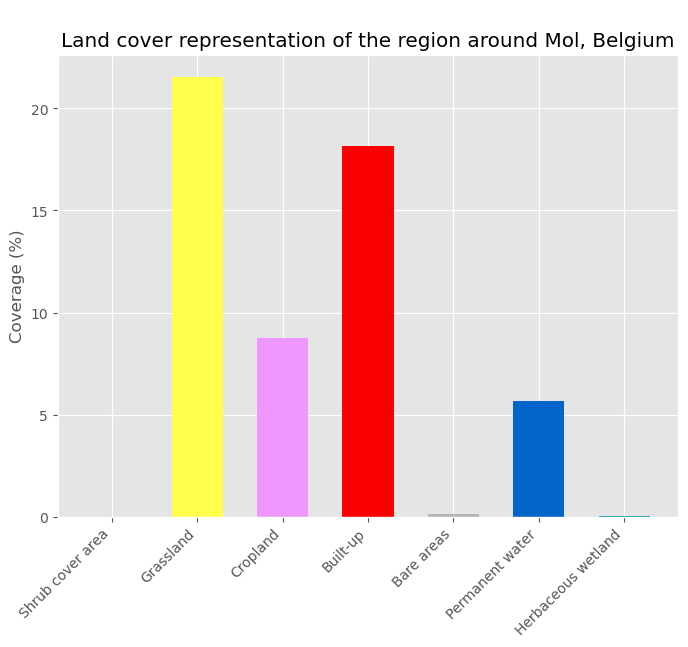

In [41]:
# Count the number of occurences (in pixels) for each class of the WorldCover product. 
import numpy as np
from utils.labels import legend_dict
from matplotlib import style

style.use('ggplot')

values, occurences = np.unique(img.data[0], return_counts=True)

occurences = occurences / occurences.sum() * 100
label_names = [legend_dict[val] for val in values]
values_colors = label_to_rgb(values.reshape(-1, 1)).squeeze()


fix, ax = plt.subplots(figsize=(8, 6))
ax.bar(x=label_names[1:], height=occurences[1:], color=values_colors[1:], width=0.6)
ax.set_title('\nLand cover representation of the region around Mol, Belgium')
ax.set
ax.set_ylabel('Coverage (%)')
plt.xticks(rotation=45, ha='right')
fig.show()